#Лабораторная работа 1: «Метод обратного распространения ошибки»

## Загрузка и проверка данных

Установка и подключение библиотек:

In [40]:
!pip install idx2numpy
!pip install wget

In [41]:
import matplotlib.pyplot as plt
import numpy as np

import idx2numpy
import os
import wget
import time

Загрузка MNIST:

In [42]:
url_mnist_path = "https://raw.githubusercontent.com/Marina-Labinskaya/deep-learning-datasets/main/MNIST"

def load_dataset(dataset_path):

  train_images = wget.download(os.path.join(dataset_path, 'train-images.idx3-ubyte'))
  train_labels = wget.download(os.path.join(dataset_path, 'train-labels.idx1-ubyte'))
  test_images = wget.download(os.path.join(dataset_path, 't10k-images.idx3-ubyte'))
  test_labels = wget.download(os.path.join(dataset_path, 't10k-labels.idx1-ubyte'))

  x_train = idx2numpy.convert_from_file(train_images)
  y_train = idx2numpy.convert_from_file(train_labels)
  x_test = idx2numpy.convert_from_file(test_images)
  y_test = idx2numpy.convert_from_file(test_labels)
  return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_dataset(url_mnist_path)

Размеры обучающей и тестовой выборки:

In [43]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


Проверим загруженные данные: выберем случайные изображения

In [44]:
def draw_samples(x_set, y_set, size = 5):
  quantity = size ** 2
  for i in range(quantity):
    indexes = np.random.randint(low=0, high=x_set.shape[0], size=quantity)

  fig, axs = plt.subplots(size, size)
  fig.suptitle("MNIST samples")

  for i in range(size):
    for j in range(size):
      axs[i, j].imshow(x_set[indexes[i * size + j]], cmap='gray')
      axs[i, j].axis('off')
      axs[i, j].set_title(f"label: {y_set[indexes[i * size + j]]}")

  plt.tight_layout()
  plt.show()

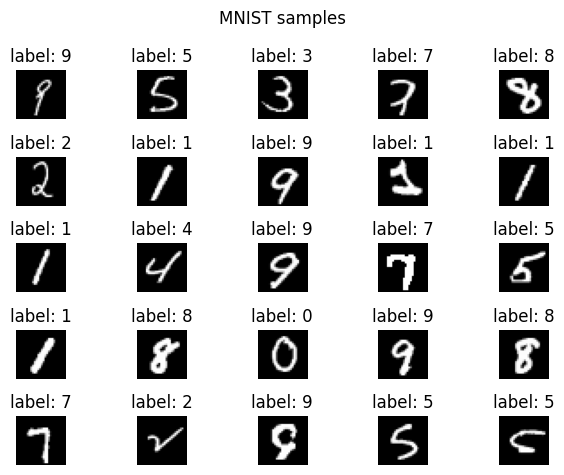

In [45]:
draw_samples(x_train, y_train)

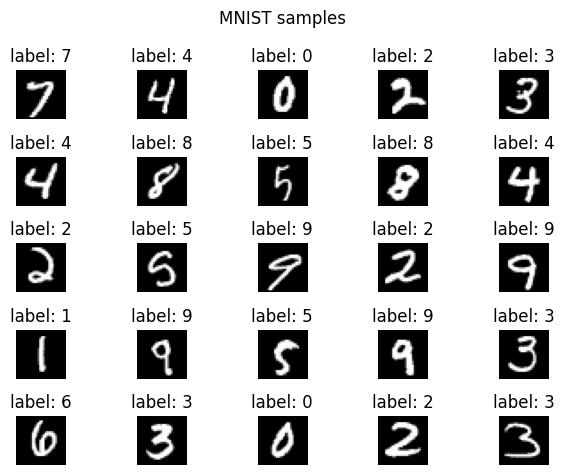

In [46]:
draw_samples(x_test, y_test)

# Конфигурация нейронной сети:

Входной слой содержит `w x h = 28x28` нейронов.

Выходной слой содержит `k=10` нейронов.

Скрытый слой содержит `s` нейронов (параметр).

Скорость обучения (`learning rate`), размер пачки данных (`batch size`), количество эпох являются параметрами метода обучения.

В качестве функции активации на скрытом слое используется функция `ReLU`.

В качестве функции активации на выходном слое используется функция `softmax`.

Входной слой не содержит функцию активации.

В качестве функции ошибки используется кросс-энтропия.

Зададим параметры:

In [47]:
input_layer_size = 28*28
output_layer_size = 10
hidden_layer_size = 300
learning_rate = 0.1
batch_size = 32 # in [8, 64]
epoch_quantity = 20

###Преобразование данных: двумерное представление (28x28) в массив длиной 28*28=784, нормализация значений пикселей

In [48]:
x_train = x_train.reshape(x_train.shape[0], 28 * 28) / 255
x_test = x_test.reshape(x_test.shape[0], 28 * 28) / 255

y_train = np.eye(output_layer_size)[y_train]
y_test = np.eye(output_layer_size)[y_test]

## Функция активации (ReLU), её производная, Softmax, кросс-энтропия

In [49]:
def relu(x):
  return np.maximum(0, x)

def relu_derivative(x):
  return np.where(x > 0, 1, 0)

def softmax(u):
  exp = np.exp(u - np.max(u, axis = 1, keepdims = True))
  return exp / np.sum(exp, axis=1, keepdims=True)

def cross_entropy(y, u):
  return np.mean(-np.sum(y * np.log(u), axis = 1))

# Реализация нейронной сети

In [53]:
class neural_network:
    def __init__(self, input_layer_size, output_layer_size, hidden_layer_size, learning_rate, batch_size):
      self.input_layer_size = input_layer_size
      self.output_layer_size = output_layer_size
      self.hidden_layer_size = hidden_layer_size
      self.learning_rate = learning_rate
      self.batch_size = batch_size

      xavier_const0 = np.sqrt(6 / (input_layer_size + hidden_layer_size))
      xavier_const1 = np.sqrt(6 / (hidden_layer_size + output_layer_size))
      self.w0 = np.random.uniform(-xavier_const0, xavier_const0, [input_layer_size, hidden_layer_size])
      self.w1 = np.random.uniform(-xavier_const1, xavier_const1, [hidden_layer_size, output_layer_size])

      self.b0 = np.zeros((1, hidden_layer_size))
      self.b1 = np.zeros((1, output_layer_size))


    def forward(self, x):
        self.z0 = np.matmul(x, self.w0) + self.b0
        self.v = relu(self.z0)
        self.z1 = np.matmul(self.v, self.w1) + self.b1
        self.u = softmax(self.z1)

    def backward(self, x, y):
        error_u = (self.u - y) / self.u.shape[0]
        error_v = np.matmul(error_u, self.w1.T) * relu_derivative(self.z0)

        self.w1 -= self.learning_rate * np.matmul(self.v.T, error_u)
        self.w0 -= self.learning_rate * np.matmul(x.T, error_v)

        self.b1 -= self.learning_rate * np.sum(error_u, axis = 0, keepdims = True)
        self.b0 -= self.learning_rate * np.sum(error_v, axis = 0, keepdims = True)


    def train_one(self, x_train, y_train):
        for i in range(0, len(x_train), self.batch_size):
            x_batch = x_train[i:i + self.batch_size]
            y_batch = y_train[i:i + self.batch_size]

            self.forward(x_batch)
            self.backward(x_batch, y_batch)

        self.forward(x_train)

    def train(self, x_train, y_train, epochs_quantity):
        start_summary_time = time.time()
        for epoch in range(epochs_quantity):
            start = time.time()

            self.train_one(x_train, y_train)

            curr_cross_entropy = cross_entropy(y_train, self.u)
            curr_accuracy = np.mean(np.argmax(y_train, axis = 1) == np.argmax(self.u, axis = 1))

            end = time.time()

            print(f'epoch: {epoch}, error= {curr_cross_entropy:.5f}, accuracy= {curr_accuracy:.5f}, t= {(end - start):.2f} s')

        end_summary_time = time.time()
        print(f'summary t= {(end_summary_time - start_summary_time):.2f} s')

    def test(self, x_test, y_test):
        start_summary_time = time.time()
        self.forward(x_test)

        test_cross_entropy = cross_entropy(y_test, self.u)
        test_accuracy = np.mean(np.argmax(y_test, axis = 1) == np.argmax(self.u, axis = 1))

        end_summary_time = time.time()

        print(f't= {(end_summary_time - start_summary_time):.2f} s, error= {test_cross_entropy:5f}, accuracy= {test_accuracy:5f}')

# Обучение модели

In [56]:
nn = neural_network(input_layer_size=input_layer_size, output_layer_size=output_layer_size,
                    hidden_layer_size=hidden_layer_size, learning_rate=learning_rate,
                    batch_size=batch_size)

nn.train(x_train, y_train, epoch_quantity)

epoch: 0, error= 0.16675, accuracy= 0.95017, t= 6.93 s
epoch: 1, error= 0.10999, accuracy= 0.96725, t= 6.92 s
epoch: 2, error= 0.08260, accuracy= 0.97487, t= 6.83 s
epoch: 3, error= 0.06529, accuracy= 0.98080, t= 6.58 s
epoch: 4, error= 0.05329, accuracy= 0.98448, t= 7.07 s
epoch: 5, error= 0.04429, accuracy= 0.98723, t= 6.47 s
epoch: 6, error= 0.03826, accuracy= 0.98883, t= 7.03 s
epoch: 7, error= 0.03242, accuracy= 0.99080, t= 6.30 s
epoch: 8, error= 0.02837, accuracy= 0.99220, t= 7.36 s
epoch: 9, error= 0.02478, accuracy= 0.99368, t= 6.00 s
epoch: 10, error= 0.02191, accuracy= 0.99445, t= 7.57 s
epoch: 11, error= 0.01960, accuracy= 0.99523, t= 6.06 s
epoch: 12, error= 0.01764, accuracy= 0.99598, t= 7.68 s
epoch: 13, error= 0.01625, accuracy= 0.99623, t= 6.05 s
epoch: 14, error= 0.01433, accuracy= 0.99677, t= 7.73 s
epoch: 15, error= 0.01326, accuracy= 0.99717, t= 6.11 s
epoch: 16, error= 0.01220, accuracy= 0.99747, t= 7.69 s
epoch: 17, error= 0.01107, accuracy= 0.99780, t= 6.00 s
ep

#Тестирование модели

In [57]:
nn.test(x_test, y_test)

t= 0.20 s, error= 0.068355, accuracy= 0.979000
